In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [70]:
stock_symbol = 'FB' # Stock Symbol Google / Alphabet
# last 5 years data with interval 1 day
data = yf.download(tickers=stock_symbol, period='10y', interval='1d')
s = pd.Series(list(range(0, len(data))))
data.set_index(s, inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
0,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [71]:
data_training_size = int(len(data)*0.7)
data_test_size = len(data) - data_training_size
data_training, data_test = data.iloc[0:data_training_size,:], data.iloc[data_training_size:len(data),:]
data_training = data_training.drop(['Adj Close'], axis=1)
data_test = data_test.drop(['Adj Close'], axis=1)
data_training.head()

,Open,High,Low,Close,Volume
0,42.049999,45.000000,38.000000,38.230000,573576400
1,36.529999,36.660000,33.000000,34.029999,168192700
2,32.610001,33.590000,30.940001,31.000000,101786600
3,31.370001,32.500000,31.360001,32.000000,73600000
4,32.950001,33.209999,31.770000,33.029999,50237200


In [72]:
sc = MinMaxScaler()
training_data = sc.fit_transform(data_training)
training_data

array([[0.12128111, 0.13341652, 0.10395486, 0.10261801, 1.        ],
       [0.09335154, 0.09178937, 0.07853803, 0.08159383, 0.28587298],
       [0.07351751, 0.07646618, 0.06806629, 0.06642639, 0.16889149],
       ...,
       [0.63180528, 0.63104567, 0.6289142 , 0.63322819, 0.02870152],
       [0.63246307, 0.6303469 , 0.62672831, 0.63307803, 0.01798936],
       [0.63281721, 0.63433992, 0.63552259, 0.63107575, 0.01232227]])

In [73]:
window = 60# check that window is less than shape[0]
x_train = []
y_train = []
for i in range(window, training_data.shape[0]):
    # take from current minus 60 first dimension, empty seconds dimension to grab all 5
    x_train.append(training_data[i-window:i])
    y_train.append(training_data[i, 0]) # zero second dimension only to grab which result should be
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((1613, 60, 5), (1613,))

In [74]:
model = keras.models.Sequential([
    # 50 nodes comming out, return sequences means returns the data as it enters
    # input shape entering is window, result (60, 5) -> five data all the table
    keras.layers.LSTM(units=80, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 5)),
    # Drop 20% random -> regularization to avoid exploding gradient
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units=80, activation='relu', return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(units=80, activation='relu', return_sequences=True),
    keras.layers.Dropout(0.4),
    # the last one never must have return sequences true, bc you dont want your input to be the output
    # you want only a result
    keras.layers.LSTM(units=120, activation='relu'),
    keras.layers.Dropout(0.5),
    # output layer, dense layer, return one result -> units
    keras.layers.Dense(units=1)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 60, 80)            27520     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 80)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 60, 80)            51520     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 80)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 60, 80)            51520     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 80)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 120)              

In [84]:
model.compile(
    optimizer='adam', #already does a batch aproach, re listen the podcast to remember later
    # adam algorithm is stochastic gradient decent, using batch but different from SGD uses adam algorithm to optimize
    loss = 'mean_squared_error'
)
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


2021-11-16 17:41:50.153218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 612s 12s/step - loss: 0.0051
Epoch 2/10
51/51 [==============================] - 610s 12s/step - loss: 0.0039
Epoch 3/10
51/51 [==============================] - 610s 12s/step - loss: 0.0036
Epoch 4/10
51/51 [==============================] - 614s 12s/step - loss: 0.0035
Epoch 5/10
51/51 [==============================] - 614s 12s/step - loss: 0.0035
Epoch 6/10
51/51 [==============================] - 615s 12s/step - loss: 0.0033
Epoch 7/10
51/51 [==============================] - 617s 12s/step - loss: 0.0034
Epoch 8/10
51/51 [==============================] - 615s 12s/step - loss: 0.0038
Epoch 9/10
51/51 [==============================] - 613s 12s/step - loss: 0.0031
Epoch 10/10
51/51 [==============================] - 613s 12s/step - loss: 0.0029


In [86]:
past_window_days = data_training.tail(window)
# get window size of previous data to continue from the training data to the test data
# that way we put a link between test and time line data

df = past_window_days.append(data_test, ignore_index = True)
df

,Open,High,Low,Close,Volume
0,155.399994,159.460007,155.009995,158.779999,19180100
1,159.559998,160.490005,157.949997,159.419998,17592000
2,158.509995,158.660004,153.279999,154.919998,21675100
3,155.860001,157.350006,153.550003,154.050003,19761300
4,154.759995,157.339996,154.460007,154.779999,15424700
...,...,...,...,...,...
773,332.489990,333.190002,325.510010,327.640015,21872600
774,329.820007,332.459991,327.000000,327.739990,12376600
775,330.179993,341.859985,329.779999,340.890015,25387200
776,344.339996,353.649994,343.200012,347.559998,25059000


In [87]:
inputs = sc.transform(df) # we transfor the data into an array and then gather the window sizes with the prediction

x_test = []
y_test = []
for i in range(window, inputs.shape[0]):
    # take from current minus 60 first dimension, empty seconds dimension to grab all 5
    x_test.append(inputs[i-window:i])
    y_test.append(inputs[i, 0]) # zero second dimension only to grab which result should be
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

array([[0.69479859, 0.7047168 , 0.69875962, 0.70606197, 0.02337125],
       [0.71584698, 0.70985779, 0.71370473, 0.70926565, 0.02057364],
       [0.71053427, 0.70072377, 0.68996541, 0.68673974, 0.02776646],
       ...,
       [1.57913373, 1.6151235 , 1.5871797 , 1.61766038, 0.03430572],
       [1.65077917, 1.67397056, 1.65539856, 1.65104869, 0.03372756],
       [1.64819867, 1.63903171, 1.64355423, 1.62677074, 0.00617845]])

In [89]:
y_pred = model.predict(x_test)

# un scale the values to normal amount of google shares
scale = (1/sc.scale_[0]) # scaling label -> amount that use scaler to scale
# every single value of scale_ is the factor that was use for every single value in the scaler
# sc.scale_[0] is the scaler factor
# we do the 1/scale to do the reverse and have the original numbers
sc.scale_, sc.scale_[0], scale

y_pred_final = y_pred*scale
y_test_final = y_test*scale
# normal scales

2021-11-16 19:24:04.017633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[0.5871101 ],
       [0.5909943 ],
       [0.5958951 ],
       [0.60162157],
       [0.6079391 ],
       [0.61455154],
       [0.6211817 ],
       [0.6275158 ],
       [0.6332419 ],
       [0.63823915],
       [0.6425197 ],
       [0.6460747 ],
       [0.6488051 ],
       [0.6510615 ],
       [0.6535679 ],
       [0.6570111 ],
       [0.66193676],
       [0.6686669 ],
       [0.6769757 ],
       [0.6863483 ],
       [0.69619536],
       [0.70590466],
       [0.71494496],
       [0.7229098 ],
       [0.729513  ],
       [0.7346038 ],
       [0.73822314],
       [0.7404414 ],
       [0.74141747],
       [0.74144787],
       [0.740903  ],
       [0.74003834],
       [0.73903227],
       [0.73801833],
       [0.7371396 ],
       [0.7365517 ],
       [0.73653454],
       [0.7372127 ],
       [0.7385455 ],
       [0.7405146 ],
       [0.74310285],
       [0.7462558 ],
       [0.7496841 ],
       [0.7527633 ],
       [0.75483936],
       [0.75561076],
       [0.7551538 ],
       [0.753

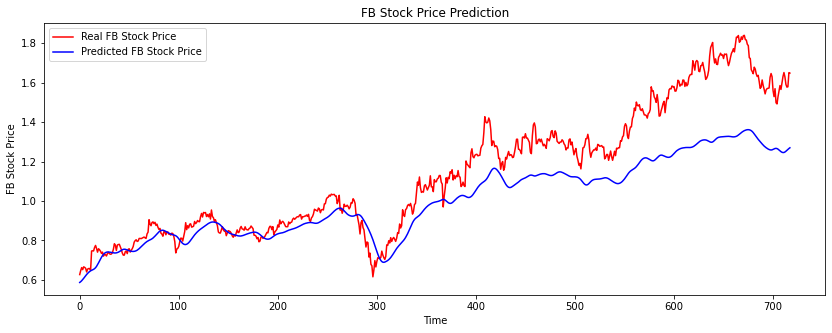

In [93]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color='red', label='Real FB Stock Price')
plt.plot(y_pred, color='blue', label='Predicted FB Stock Price')
plt.title('FB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show()

In [94]:
model.evaluate(x_test, y_test)

2021-11-17 03:13:48.768596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 15s 588ms/step - loss: 0.0375


0.037505172193050385